In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def generate_random_symmetric_matrix(dim):
    M_random = torch.rand((dim,dim)) - 0.5
    return 0.5 * (M_random.T + M_random)

In [4]:
class EigenNet(nn.Module):
    def __init__(self, dim, hidden_layers):
        super(EigenNet,self).__init__()
        
        # The input layer coincides with the input vector,
        # so technically nothing needs to be done here. We add a noop idendity layer for conceptional clarity.
        self.eye = nn.Identity()
        
        # Hidden Layers are assumed to be fully connected acyclic ReLu nodes with hidden_layer nodes each 
        prev_nodes_per_layer = dim;
        hidden = []
        for nodes_per_layer in hidden_layers:
            hidden += [nn.Linear(prev_nodes_per_layer, nodes_per_layer), nn.ReLU()]
            prev_nodes_per_layer = nodes_per_layer
        self.ff_relu_graph = nn.Sequential(*hidden)
            
        # Output Layer is assumed to be linear
        self.output = nn.Linear(prev_nodes_per_layer, dim)
        
    def forward(self, x): 
        return self.output(self.ff_relu_graph(self.eye(x)))

In [5]:
# Eigenvalue Problem and Initial conditions
dim = 6
A = generate_random_symmetric_matrix(dim)

print(f"A = {A}")

A = tensor([[ 0.4440, -0.3717,  0.0325,  0.0236,  0.0277,  0.1832],
        [-0.3717, -0.0225, -0.2348,  0.3134, -0.0687, -0.1157],
        [ 0.0325, -0.2348, -0.3327, -0.1578, -0.1872, -0.2145],
        [ 0.0236,  0.3134, -0.1578,  0.0104,  0.0852,  0.1180],
        [ 0.0277, -0.0687, -0.1872,  0.0852,  0.2527,  0.3258],
        [ 0.1832, -0.1157, -0.2145,  0.1180,  0.3258, -0.0010]])


In [6]:
def eigendecomposition(A, verbose=True):
    dim = A.shape[-1]
    max_ev = torch.sqrt(torch.sum(A * A))
    
    x_init = torch.rand(dim).reshape(1,dim)
    x_init /= torch.sqrt(x_init @ x_init.T).item()
    
    # Hyperparameters for model and learning
    hidden_layers = [100,100,100]
    epochs=500

    eigenNN = EigenNet(dim, hidden_layers)
    optimizer = torch.optim.Adam(eigenNN.parameters())
    loss_fn = torch.nn.MSELoss()
    
    if verbose:
        mean_loss = 0.0
        report_after_e_epochs = 50
        eigenvalue_evolution = []
        print(f'{"Hyperparameters":-^60}')
        print(f'{"Network Layers/Nodes:":<40}{hidden_layers}')
        print(f'{"Iterations:":<40}{epochs:>20}')
        print(f'{"":-^60}')
        print(f'{"Epoch":^30}|{"Mean Loss":^30}')
        
    for e in range(epochs):
        x = eigenNN(x_init)
        fx = x @ ( x @ x.T * A ) + (1 - x @ A @ x.T) @ x
        eigenvalue = (x @ A @ x.T) / (x @ x.T)
        loss =  loss_fn(x,fx) + (max_ev - eigenvalue)**2
                                        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if verbose:
            mean_loss = mean_loss + loss.item()/report_after_e_epochs
    

        if verbose and e % report_after_e_epochs==0 and e > 0:
            print(f'{e:^30}|{mean_loss:>29.6e}')
            mean_loss = 0.0
            eigenvalue_evolution.append(eigenvalue.item())
    
    if verbose:
        print(f'{"Iteration limit reached":-^60}')
        return eigenNN, eigenvalue_evolution
    else:
        return x, eigenvalue

In [7]:
# Eigenvalue Problem
dim = 6
A = generate_random_symmetric_matrix(dim)
print(f"A = {A}")

#Ground Truth
eigenvalues, eigenvectors = np.linalg.eig(A)

# Sort in descending order
permutation = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[permutation]
eigenvectors = eigenvectors[permutation]
print(f"max{{ Sp(A) }} = {np.max(eigenvalues)}")

A = tensor([[ 0.4173, -0.3513, -0.1415,  0.2873,  0.3947, -0.0965],
        [-0.3513,  0.3898, -0.2916,  0.3844,  0.1352,  0.0348],
        [-0.1415, -0.2916, -0.1458,  0.2446,  0.2747,  0.1743],
        [ 0.2873,  0.3844,  0.2446,  0.3985, -0.0465,  0.1773],
        [ 0.3947,  0.1352,  0.2747, -0.0465,  0.1407,  0.0290],
        [-0.0965,  0.0348,  0.1743,  0.1773,  0.0290, -0.0871]])
max{ Sp(A) } = 0.8527315258979797


In [8]:
eigenvector_network , eigenvalue_evolution = eigendecomposition(A)
print(f"max{{ Sp(A) }} = {eigenvalue_evolution[-1]}")

----------------------Hyperparameters-----------------------
Network Layers/Nodes:                   [100, 100, 100]
Iterations:                                              500
------------------------------------------------------------
            Epoch             |          Mean Loss           
              50              |                 5.689138e-01
             100              |                 4.226695e-01
             150              |                 4.064045e-01
             200              |                 4.062845e-01
             250              |                 4.062839e-01
             300              |                 4.062839e-01
             350              |                 4.062839e-01
             400              |                 4.062839e-01
             450              |                 4.062839e-01
------------------Iteration limit reached-------------------
max{ Sp(A) } = 0.852731466293335


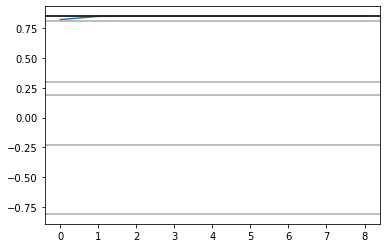

In [9]:
ev_nn = eigenvalue_evolution[-1]
closest_true_ev = eigenvalues[(np.abs(eigenvalues - ev_nn)).argmin()]
          
plt.plot(eigenvalue_evolution)
for ev in eigenvalues:
    plt.axhline(y=ev, color="darkgray")
    
plt.axhline(y=closest_true_ev, color="k")
plt.show()